In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf
import keras
import sys
import os
import random
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import accuracy_score, classification_report
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from tensorflow.keras import regularizers
from keras.layers import Conv2D, MaxPool2D, Dense, Dropout, BatchNormalization, Flatten, Rescaling, RandomZoom,MaxPooling2D
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50V2, InceptionV3, ResNet152V2, Xception, DenseNet201,EfficientNetB3,ResNet50,MobileNetV2
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import Adam, Adamax
from keras import Input

## Metrics Plotting function

In [3]:
def evaluation_metrics(model_history):
    acc=model_history.history['accuracy']
    val_acc = model_history.history['val_accuracy']
    loss = model_history.history['loss']
    val_loss = model_history.history['val_loss']
 
    epochs = range(len(acc))
 
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
 
    plt.figure()
 
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
 
    plt.show(block=False)

## Submission generation function

In [4]:
def pred_submission(model):
    class_names = {idx:name for name, idx in train_data_generator.class_indices.items()}
    preds = model.predict(test_data_generator, steps = len(test_data_generator.filenames))
    preds = np.argmax(preds, axis=-1)
    dataframe_test['label_coded']=preds
    dataframe_test['label']=dataframe_test.label_coded.map(class_names)
    dataframe_test.drop('label_coded',axis=1,inplace=True)
    dataframe_test.to_csv('submission.csv', index=False)

## Fetching datalinks

In [5]:
image_train_path = '/kaggle/input/coin-currency-identification/train'
image_test_path = '/kaggle/input/coin-currency-identification/test'
labels_train_path = '/kaggle/input/coin-currency-identification/Training_set.csv'
labels_test_path = '/kaggle/input/coin-currency-identification/Testing_set.csv'

## Plotting sample training dataset images

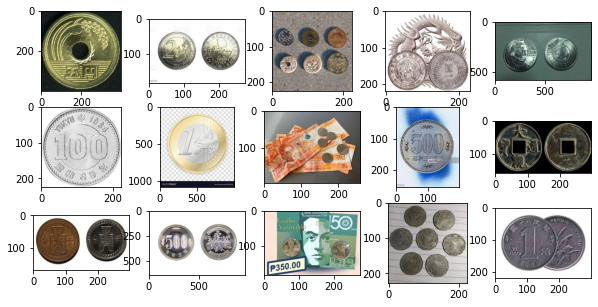

In [6]:
fig = plt.figure(figsize=(10,5))
for image in range(len(os.listdir(image_train_path)[0:15])):
    plt.subplot(3,5,image+1)
    disp = plt.imread(os.path.join(image_train_path,os.listdir(image_train_path)[image]))
    plt.imshow(disp)

## Training and Testing dataset generator with batch size = 64

In [7]:
batchsize=64

train_gen = ImageDataGenerator(rescale=1/255.0,
                               rotation_range=40,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               shear_range=0.2,
                               zoom_range=0.2,
                               validation_split=0.05,
                               horizontal_flip=True)
test_gen = ImageDataGenerator(rescale=1/255.0,horizontal_flip=True)

dataframe_train = pd.read_csv(labels_train_path)

train_data_generator = train_gen.flow_from_dataframe(dataframe=dataframe_train,directory=image_train_path,x_col="filename",
    y_col="label",subset='training',batch_size=batchsize,target_size=(224, 224),class_mode="categorical",shuffle=True,seed=7)

valid_data_generator = train_gen.flow_from_dataframe(dataframe=dataframe_train,directory=image_train_path,x_col="filename",
    y_col="label",subset='validation',batch_size=batchsize,target_size=(224, 224),class_mode="categorical",shuffle=True,seed=7)

dataframe_test = pd.read_csv(labels_test_path)

test_data_generator = test_gen.flow_from_dataframe(dataframe=dataframe_test,directory=image_test_path,x_col="filename",
    target_size=(224,224),batch_size=1,class_mode=None,shuffle=False)

Found 817 validated image filenames belonging to 6 classes.
Found 43 validated image filenames belonging to 6 classes.
Found 369 validated image filenames.


## Xception Net model with lr = 0.00003

In [8]:
with tf.device('/GPU:0'):
    
    base_model_one = Xception(include_top=False,weights="imagenet",input_shape=(224,224,3),pooling=None,classes=6,classifier_activation="softmax")
    base_model_one.trainable=True

    model_one = Sequential()
    model_one.add(base_model_one)
    model_one.add(GlobalAveragePooling2D())
    model_one.add(Dense(6, activation='softmax'))
    model_one.compile(optimizer= Adam(learning_rate=0.00003), loss='categorical_crossentropy',metrics=['accuracy'])

    #reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=1, verbose=0, mode="min", cooldown=0, min_lr=0)
    #early_stop_callback = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

    model_one_history = model_one.fit(train_data_generator,validation_data = valid_data_generator,
              epochs=25)

2022-11-02 07:11:51.778988: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-02 07:11:51.779948: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-02 07:11:51.965617: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-02 07:11:51.966595: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-02 07:11:51.967432: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

83697664/83683744 [==============================] - 1s 0us/step


2022-11-02 07:12:00.130687: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/25


2022-11-02 07:12:07.107671: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


13/13 [==============================] - 48s 2s/step - loss: 1.7873 - accuracy: 0.1971 - val_loss: 1.7792 - val_accuracy: 0.2326
Epoch 2/25
13/13 [==============================] - 21s 2s/step - loss: 1.6714 - accuracy: 0.3537 - val_loss: 1.5997 - val_accuracy: 0.4186
Epoch 3/25
13/13 [==============================] - 22s 2s/step - loss: 1.5504 - accuracy: 0.5104 - val_loss: 1.5672 - val_accuracy: 0.3953
Epoch 4/25
13/13 [==============================] - 21s 2s/step - loss: 1.4224 - accuracy: 0.5838 - val_loss: 1.4327 - val_accuracy: 0.5116
Epoch 5/25
13/13 [==============================] - 21s 2s/step - loss: 1.3055 - accuracy: 0.6438 - val_loss: 1.3649 - val_accuracy: 0.5349
Epoch 6/25
13/13 [==============================] - 22s 2s/step - loss: 1.1826 - accuracy: 0.6903 - val_loss: 1.2959 - val_accuracy: 0.5814
Epoch 7/25
13/13 [==============================] - 21s 2s/step - loss: 1.0586 - accuracy: 0.7356 - val_loss: 1.2552 - val_accuracy: 0.5116
Epoch 8/25
13/13 [=============

## Plotting Xception model with bs=64 and lr=0.00003

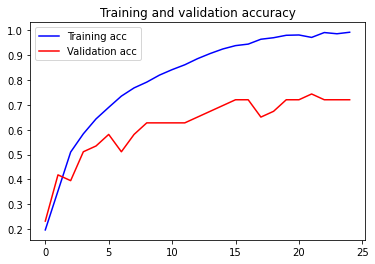

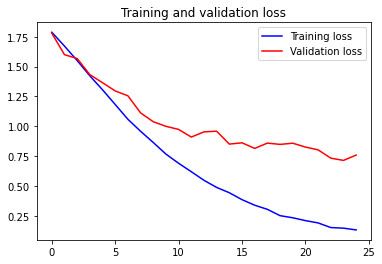

In [9]:
evaluation_metrics(model_one_history)

## Training and Testing dataset generator with batch size = 64

In [10]:
batchsize=64

train_gen = ImageDataGenerator(rescale=1/255.0,
                               rotation_range=40,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               shear_range=0.2,
                               zoom_range=0.2,
                               validation_split=0.05,
                               horizontal_flip=True)
test_gen = ImageDataGenerator(rescale=1/255.0,horizontal_flip=True)

dataframe_train = pd.read_csv(labels_train_path)

train_data_generator = train_gen.flow_from_dataframe(dataframe=dataframe_train,directory=image_train_path,x_col="filename",
    y_col="label",subset='training',batch_size=batchsize,target_size=(224, 224),class_mode="categorical",shuffle=True,seed=7)

valid_data_generator = train_gen.flow_from_dataframe(dataframe=dataframe_train,directory=image_train_path,x_col="filename",
    y_col="label",subset='validation',batch_size=batchsize,target_size=(224, 224),class_mode="categorical",shuffle=True,seed=7)

dataframe_test = pd.read_csv(labels_test_path)

test_data_generator = test_gen.flow_from_dataframe(dataframe=dataframe_test,directory=image_test_path,x_col="filename",
    target_size=(224,224),batch_size=1,class_mode=None,shuffle=False)

Found 817 validated image filenames belonging to 6 classes.
Found 43 validated image filenames belonging to 6 classes.
Found 369 validated image filenames.


## Xception Net model with lr = 0.0001

In [11]:
with tf.device('/GPU:0'):
    
    base_model_two = Xception(include_top=False,weights="imagenet",input_shape=(224,224,3),pooling=None,classes=6,classifier_activation="softmax")
    base_model_two.trainable=True

    model_two = Sequential()
    model_two.add(base_model_two)
    model_two.add(GlobalAveragePooling2D())
    model_two.add(Dense(6, activation='softmax'))
    model_two.compile(optimizer= Adam(learning_rate=0.0001), loss='categorical_crossentropy',metrics=['accuracy'])

    #reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=1, verbose=0, mode="min", cooldown=0, min_lr=0)
    #early_stop_callback = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

    model_two_history = model_two.fit(train_data_generator,validation_data = valid_data_generator,
              epochs=25)

Epoch 1/25
13/13 [==============================] - 27s 2s/step - loss: 1.6925 - accuracy: 0.3427 - val_loss: 1.6742 - val_accuracy: 0.3953
Epoch 2/25
13/13 [==============================] - 21s 2s/step - loss: 1.2962 - accuracy: 0.6157 - val_loss: 1.4247 - val_accuracy: 0.3721
Epoch 3/25
13/13 [==============================] - 22s 2s/step - loss: 0.9523 - accuracy: 0.7307 - val_loss: 1.3147 - val_accuracy: 0.4651
Epoch 4/25
13/13 [==============================] - 22s 2s/step - loss: 0.6772 - accuracy: 0.8225 - val_loss: 1.2054 - val_accuracy: 0.5349
Epoch 5/25
13/13 [==============================] - 21s 2s/step - loss: 0.4859 - accuracy: 0.8800 - val_loss: 1.0168 - val_accuracy: 0.5814
Epoch 6/25
13/13 [==============================] - 22s 2s/step - loss: 0.3404 - accuracy: 0.9376 - val_loss: 1.0354 - val_accuracy: 0.6047
Epoch 7/25
13/13 [==============================] - 21s 2s/step - loss: 0.2450 - accuracy: 0.9510 - val_loss: 0.9801 - val_accuracy: 0.5581
Epoch 8/25
13/13 [==

## Plotting Xception model with bs=64 and lr=0.0001

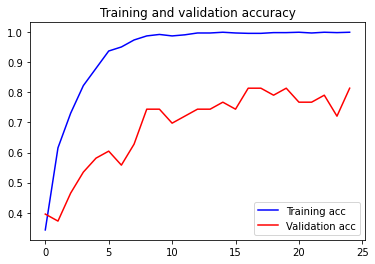

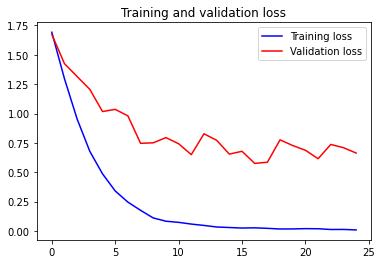

In [12]:
evaluation_metrics(model_two_history)

## Training and Testing dataset generator with batch size = 32

In [13]:
batchsize=32

train_gen = ImageDataGenerator(rescale=1/255.0,
                               rotation_range=40,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               shear_range=0.2,
                               zoom_range=0.2,
                               validation_split=0.05,
                               horizontal_flip=True)
test_gen = ImageDataGenerator(rescale=1/255.0,horizontal_flip=True)

dataframe_train = pd.read_csv(labels_train_path)

train_data_generator = train_gen.flow_from_dataframe(dataframe=dataframe_train,directory=image_train_path,x_col="filename",
    y_col="label",subset='training',batch_size=batchsize,target_size=(224, 224),class_mode="categorical",shuffle=True,seed=7)

valid_data_generator = train_gen.flow_from_dataframe(dataframe=dataframe_train,directory=image_train_path,x_col="filename",
    y_col="label",subset='validation',batch_size=batchsize,target_size=(224, 224),class_mode="categorical",shuffle=True,seed=7)

dataframe_test = pd.read_csv(labels_test_path)

test_data_generator = test_gen.flow_from_dataframe(dataframe=dataframe_test,directory=image_test_path,x_col="filename",
    target_size=(224,224),batch_size=1,class_mode=None,shuffle=False)

Found 817 validated image filenames belonging to 6 classes.
Found 43 validated image filenames belonging to 6 classes.
Found 369 validated image filenames.


## Xception Net model with lr = 0.00003

In [14]:
with tf.device('/GPU:0'):
    
    base_model_three = Xception(include_top=False,weights="imagenet",input_shape=(224,224,3),pooling=None,classes=6,classifier_activation="softmax")
    base_model_three.trainable=True

    model_three = Sequential()
    model_three.add(base_model_three)
    model_three.add(GlobalAveragePooling2D())
    model_three.add(Dense(6, activation='softmax'))
    model_three.compile(optimizer= Adam(learning_rate=0.00003),loss='categorical_crossentropy',metrics=['accuracy'])

    #reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=1, verbose=0, mode="min", cooldown=0, min_lr=0)
    #early_stop_callback = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

    model_three_history = model_three.fit(train_data_generator,validation_data = valid_data_generator,
              epochs=25)

Epoch 1/25
26/26 [==============================] - 31s 930ms/step - loss: 1.7651 - accuracy: 0.2313 - val_loss: 1.6623 - val_accuracy: 0.2326
Epoch 2/25
26/26 [==============================] - 20s 755ms/step - loss: 1.5908 - accuracy: 0.4247 - val_loss: 1.5713 - val_accuracy: 0.3256
Epoch 3/25
26/26 [==============================] - 21s 777ms/step - loss: 1.4095 - accuracy: 0.5520 - val_loss: 1.4479 - val_accuracy: 0.3721
Epoch 4/25
26/26 [==============================] - 21s 787ms/step - loss: 1.2384 - accuracy: 0.6475 - val_loss: 1.2629 - val_accuracy: 0.5814
Epoch 5/25
26/26 [==============================] - 20s 768ms/step - loss: 1.0704 - accuracy: 0.7050 - val_loss: 1.1853 - val_accuracy: 0.5116
Epoch 6/25
26/26 [==============================] - 20s 772ms/step - loss: 0.9240 - accuracy: 0.7466 - val_loss: 1.0183 - val_accuracy: 0.6047
Epoch 7/25
26/26 [==============================] - 20s 758ms/step - loss: 0.8253 - accuracy: 0.7638 - val_loss: 1.0040 - val_accuracy: 0.6047

## Plotting Xception model with bs=32 and lr=0.00003

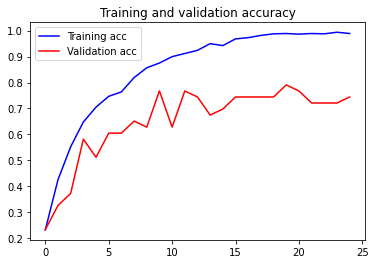

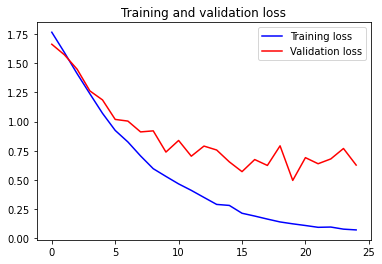

In [15]:
evaluation_metrics(model_three_history)

## Training and Testing dataset generator with batch size = 32¶

In [16]:
batchsize=32

train_gen = ImageDataGenerator(rescale=1/255.0,
                               rotation_range=40,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               shear_range=0.2,
                               zoom_range=0.2,
                               validation_split=0.05,
                               horizontal_flip=True)
test_gen = ImageDataGenerator(rescale=1/255.0,horizontal_flip=True)

dataframe_train = pd.read_csv(labels_train_path)

train_data_generator = train_gen.flow_from_dataframe(dataframe=dataframe_train,directory=image_train_path,x_col="filename",
    y_col="label",subset='training',batch_size=batchsize,target_size=(224, 224),class_mode="categorical",shuffle=True,seed=7)

valid_data_generator = train_gen.flow_from_dataframe(dataframe=dataframe_train,directory=image_train_path,x_col="filename",
    y_col="label",subset='validation',batch_size=batchsize,target_size=(224, 224),class_mode="categorical",shuffle=True,seed=7)

dataframe_test = pd.read_csv(labels_test_path)

test_data_generator = test_gen.flow_from_dataframe(dataframe=dataframe_test,directory=image_test_path,x_col="filename",
    target_size=(224,224),batch_size=1,class_mode=None,shuffle=False)

Found 817 validated image filenames belonging to 6 classes.
Found 43 validated image filenames belonging to 6 classes.
Found 369 validated image filenames.


## Xception Net model with lr = 0.0001

In [17]:
with tf.device('/GPU:0'):
    
    base_model_four = Xception(include_top=False,weights="imagenet",input_shape=(224,224,3),pooling=None,classes=6,classifier_activation="softmax")
    base_model_four.trainable=True

    model_four = Sequential()
    model_four.add(base_model_four)
    model_four.add(GlobalAveragePooling2D())
    model_four.add(Dense(6, activation='softmax'))
    model_four.compile(optimizer= Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

    #reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=1, verbose=0, mode="min", cooldown=0, min_lr=0)
    #early_stop_callback = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

    model_four_history = model_four.fit(train_data_generator,validation_data = valid_data_generator,
              epochs=25)

Epoch 1/25
26/26 [==============================] - 26s 823ms/step - loss: 1.6302 - accuracy: 0.3672 - val_loss: 1.4210 - val_accuracy: 0.4651
Epoch 2/25
26/26 [==============================] - 20s 761ms/step - loss: 1.0945 - accuracy: 0.6683 - val_loss: 1.2111 - val_accuracy: 0.3953
Epoch 3/25
26/26 [==============================] - 21s 782ms/step - loss: 0.7354 - accuracy: 0.7956 - val_loss: 1.0868 - val_accuracy: 0.5581
Epoch 4/25
26/26 [==============================] - 21s 776ms/step - loss: 0.4887 - accuracy: 0.8837 - val_loss: 0.9014 - val_accuracy: 0.6512
Epoch 5/25
26/26 [==============================] - 20s 763ms/step - loss: 0.3263 - accuracy: 0.9229 - val_loss: 0.7255 - val_accuracy: 0.7209
Epoch 6/25
26/26 [==============================] - 21s 774ms/step - loss: 0.2255 - accuracy: 0.9474 - val_loss: 0.5956 - val_accuracy: 0.8372
Epoch 7/25
26/26 [==============================] - 20s 764ms/step - loss: 0.1414 - accuracy: 0.9816 - val_loss: 0.6273 - val_accuracy: 0.7907

## Plotting Xception model with bs=32 and lr=0.0001

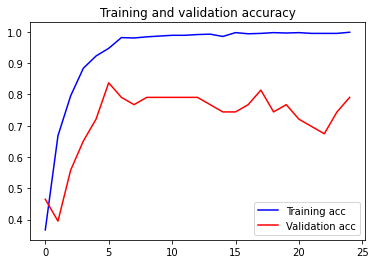

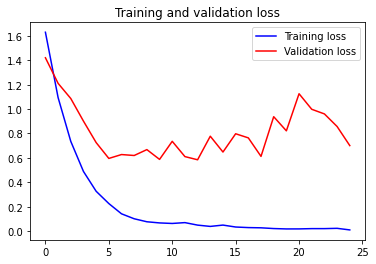

In [18]:
evaluation_metrics(model_four_history)